In [13]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
import random

# ✅ Paths
input_path = r"D:\WILD MED NO AUG"
output_path = r"D:\balanced_medicinal_plant"

# ✅ Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# ✅ Augmentation settings (clean and natural)
datagen = ImageDataGenerator(
    #rotation_range=20,            
    shear_range=0.1,              
    zoom_range=0.1,               
    brightness_range=[0.9, 1.1],  
    horizontal_flip=True          
)

# ✅ Target number of images per class
TARGET_COUNT = 400

# ✅ Loop through each folder (class)
for folder in os.listdir(input_path):
    folder_path = os.path.join(input_path, folder)
    if not os.path.isdir(folder_path):
        continue
    
    # ✅ Create output folder for each class
    output_class_path = os.path.join(output_path, folder)
    os.makedirs(output_class_path, exist_ok=True)
    
    # ✅ Get existing images
    existing_images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(existing_images)
    
    # ✅ 1. If more than 400 → Trim it down
    if current_count > TARGET_COUNT:
        print(f"✅ {folder} → Trimming {current_count - TARGET_COUNT} excess images")
        images_to_keep = random.sample(existing_images, TARGET_COUNT)
        for img_file in images_to_keep:
            img = Image.open(os.path.join(folder_path, img_file))
            img.save(os.path.join(output_class_path, img_file))
    
    # ✅ 2. If less than 400 → Augment until we reach 400
    elif current_count < TARGET_COUNT:
        print(f"✅ {folder} → Augmenting {TARGET_COUNT - current_count} images")
        augmented_count = 0
        
        while current_count + augmented_count < TARGET_COUNT:
            for img_file in existing_images:
                img_path = os.path.join(folder_path, img_file)
                img = load_img(img_path, target_size=(224, 224))
                x = img_to_array(img)
                x = np.expand_dims(x, axis=0)
                
                for batch in datagen.flow(x, batch_size=1, save_to_dir=output_class_path,
                                          save_prefix=folder, save_format='jpeg'):
                    augmented_count += 1
                    if current_count + augmented_count >= TARGET_COUNT:
                        break

    else:
        # ✅ If already exactly 400 → Just copy
        for img_file in existing_images:
            img = Image.open(os.path.join(folder_path, img_file))
            img.save(os.path.join(output_class_path, img_file))
    
    print(f"✅ {folder} → Final count = {TARGET_COUNT} ✅")

print("🚀 Augmentation and Scaling Completed!")


✅ Aavaram poo → Augmenting 52 images
✅ Aavaram poo → Final count = 400 ✅
✅ Ammampacharicy → Augmenting 271 images
✅ Ammampacharicy → Final count = 400 ✅
✅ Erukan → Augmenting 259 images
✅ Erukan → Final count = 400 ✅
✅ Karpuravalli → Augmenting 284 images
✅ Karpuravalli → Final count = 400 ✅
✅ Karunthulasi → Augmenting 267 images
✅ Karunthulasi → Final count = 400 ✅
✅ Keezhanalli → Augmenting 291 images
✅ Keezhanalli → Final count = 400 ✅
✅ Kuppaimani → Augmenting 255 images
✅ Kuppaimani → Final count = 400 ✅
✅ Manathakaali → Augmenting 212 images
✅ Manathakaali → Final count = 400 ✅
✅ Mookuthi poondu → Augmenting 197 images
✅ Mookuthi poondu → Final count = 400 ✅
✅ Mudakathan keerai → Augmenting 332 images
✅ Mudakathan keerai → Final count = 400 ✅
✅ Musumusukai → Augmenting 348 images
✅ Musumusukai → Final count = 400 ✅
✅ Naayuruvi → Augmenting 285 images
✅ Naayuruvi → Final count = 400 ✅
✅ Nochi → Augmenting 325 images
✅ Nochi → Final count = 400 ✅
✅ Oomathan → Augmenting 173 images


In [1]:
#1. Load and Preprocess Data

import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ✅ Define image size and batch size
image_size = (224, 224)
batch_size = 64

# ✅ Create an ImageDataGenerator with strong augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    channel_shift_range=0.2,
    validation_split=0.2
)

# ✅ Updated path to balanced dataset
train_generator = train_datagen.flow_from_directory(
    r"D:\balanced_medicinal_plant",
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    r"D:\balanced_medicinal_plant",
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

# ✅ Get class labels
class_labels = list(train_generator.class_indices.keys())
print(f"✅ Class Labels: {class_labels}")


Found 6574 images belonging to 21 classes.
Found 1635 images belonging to 21 classes.
✅ Class Labels: ['Aavaram poo', 'Ammampacharicy', 'Erukan', 'Karpuravalli', 'Karunthulasi', 'Keezhanalli', 'Kuppaimani', 'Manathakaali', 'Mookuthi poondu', 'Mudakathan keerai', 'Musumusukai', 'Naayuruvi', 'Nochi', 'Oomathan', 'Papaya leaf', 'Perandai', 'Thumbai', 'Thuthi', 'Thuthuvalai', 'Vallarai keerai', 'Vetrillai']


In [3]:
#🧠 2. Build the Model
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# ✅ Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# ✅ Freeze the base model
base_model.trainable = False

# ✅ Build the full model with Batch Normalization, Dropout & Extra Dense Layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

# ✅ Compile model
model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │        10,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,924,629 (11.16 MB)

 Trainable params: 666,645 (2.54 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [4]:
from sklearn.utils.class_weight import compute_class_weight

# ✅ Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# ✅ Convert to dictionary
class_weights = dict(enumerate(class_weights))
print(f"✅ Class Weights: {class_weights}")


✅ Class Weights: {0: 1.0065839840759454, 1: 1.0163883735312307, 2: 0.9938019652305367, 3: 0.9906570223025919, 4: 0.9906570223025919, 5: 1.0033577533577533, 6: 0.9938019652305367, 7: 0.9906570223025919, 8: 1.0001521375323292, 9: 1.0163883735312307, 10: 1.0130990907689936, 11: 1.0001521375323292, 12: 0.9906570223025919, 13: 0.9906570223025919, 14: 0.9969669396420989, 15: 1.0033577533577533, 16: 0.9969669396420989, 17: 1.0001521375323292, 18: 1.0065839840759454, 19: 1.0001521375323292, 20: 1.0001521375323292}


In [5]:
from tensorflow.keras.callbacks import LearningRateScheduler

# ✅ Learning rate decay scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.1
    
lr_callback = LearningRateScheduler(scheduler)


In [6]:
history = model.fit(
    train_generator,
    epochs=15,  # Start with 15 epochs, adjust if needed
    validation_data=val_generator,
    class_weight=class_weights, # ✅ Apply class weights
    callbacks=[lr_callback]
)


Epoch 1/15


C:\Users\thiru\anaconda3new\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.3994 - loss: 8.6515 - val_accuracy: 0.8752 - val_loss: 4.6031 - learning_rate: 5.0000e-04
Epoch 2/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.7946 - loss: 4.3741 - val_accuracy: 0.8985 - val_loss: 2.8664 - learning_rate: 5.0000e-04
Epoch 3/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8372 - loss: 2.8388 - val_accuracy: 0.9156 - val_loss: 1.9559 - learning_rate: 5.0000e-04
Epoch 4/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.8559 - loss: 2.0113 - val_accuracy: 0.9193 - val_loss: 1.4536 - learning_rate: 5.0000e-04
Epoch 5/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.8604 - loss: 1.5722 - val_accuracy: 0.9291 - val_loss: 1.1442 - learning_rate: 5.0000e-04
Epoch 6/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8859 - loss: 1.2714 - val_accuracy: 0.9364 - val_loss: 1.0884 - learning_rate: 5.0000e-05
Epoch 7/15
103/103 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.88

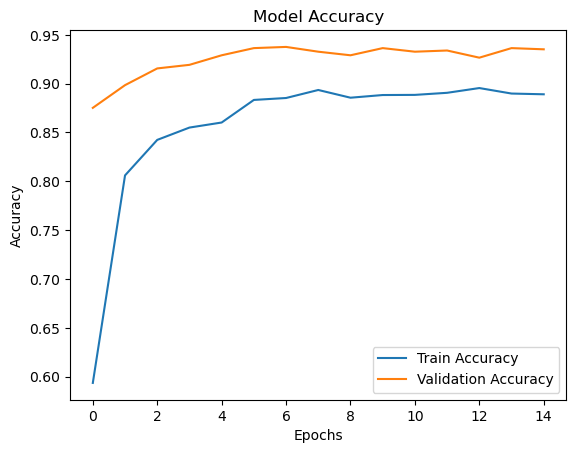

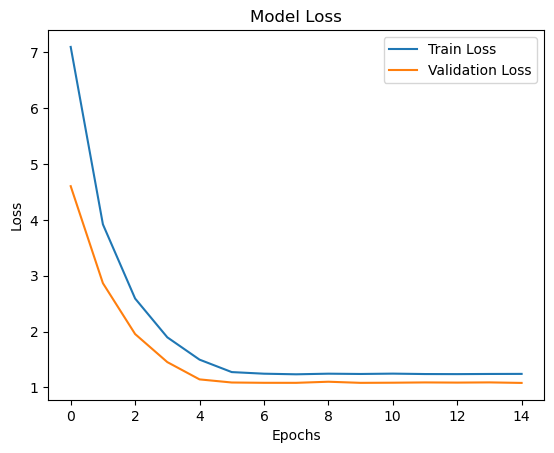

In [7]:
import matplotlib.pyplot as plt

# ✅ Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# ✅ Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [8]:
# ✅ Define medicinal uses for each leaf type
medicinal_uses = {
    'Karunthulasi': 'It has a sharp peppery taste,Anti-inflammatory and Analgesic Effects, Immunomodulatory Activity, Also boosts immunity,Antioxidant Activity',
    'Aavaram Poo': 'Used for improving skin health, regulating blood sugar levels, and treating urinary tract infections,Antidiabetic Effects,Hepatoprotective (Liver Protection) Effects,Cardioprotective Effects',
    'Ammampacharicy': 'Antimicrobial,Anthelmintic- Used to treat intestinal worms, Anti-inflammatory.',
    'Erukan': 'Antioxidant- Rich in vitamin C and glucosinolates that protect against oxidative stress,Anticancer- Contains sulforaphane, known for its ability to inhibit cancer cell growth.Cardioprotective- Reduces cholesterol and improves heart health.',
    'Karpuravalli': 'Respiratory health: Effective for cough, asthma, and bronchitis due to its expectorant properties.Antimicrobial: Contains thymol and carvacrol that inhibit bacterial growth.Anti-inflammatory: Reduces throat irritation and inflammation.Digestive health: Used to treat indigestion and flatulence.',
    'Keezhanalli': 'Hepatoprotective: Effective against hepatitis and liver disorders by protecting hepatocytes.Antiviral: Shows activity against Hepatitis B virus.Kidney health: Prevents and dissolves kidney stones.Anti-inflammatory: Reduces inflammation in liver and kidneys.',
    'Kuppaimani': 'Wound healing: Accelerates the healing of cuts and burns.Antimicrobial: Effective against Staphylococcus aureus and Candida albicans.Anthelmintic: Effective in removing intestinal worms.Respiratory health: Treats bronchitis and cough.',
    'Manathakaali': 'Liver health: Protects against liver damage and enhances detoxification.Anti-ulcer: Heals gastric ulcers by increasing mucus production.Antioxidant: Protects cells from oxidative damage.Anti-inflammatory: Reduces joint pain and swelling.',
    'Mookuthi poondu': 'Antimicrobial: Contains allicin, which inhibits bacterial growth.Anti-inflammatory: Reduces swelling and improves wound healing.Cardioprotective: Lowers cholesterol and blood pressure.Digestive health: Improves digestion and prevents bloating.',
    'Mudakathan keerai': 'Anti-inflammatory: Used to treat arthritis and joint pain.Antioxidant: Reduces oxidative stress in joints.Anti-rheumatic: Improves flexibility and reduces stiffness.Digestive aid: Treats indigestion and constipation.',
    'Musumusukai': 'Digestive health: Improves appetite and relieves indigestion.Antimicrobial: Effective against intestinal infections.Anti-inflammatory: Treats throat irritation and cough.Respiratory health: Relieves chest congestion and improves breathing.',
    'Naayuruvi': 'Anti-inflammatory: Treats swelling and joint pain.Diuretic: Increases urine flow and helps flush out toxins.Antipyretic: Reduces fever.Skin health: Treats skin infections and itching.',
    'Nochi': 'Anti-inflammatory: Effective in treating arthritis and muscle pain.Antimicrobial: Kills bacteria and promotes wound healing.Respiratory health: Used to treat cough and asthma.Menstrual health: Reduces PMS symptoms and regulates menstrual cycles.',
    'Oomathan': 'Pain relief: Contains scopolamine and atropine that reduce pain.Respiratory health: Used to treat asthma (in small doses).Sedative: Induces sleep and reduces anxiety.⚠️ Toxic in high doses – Must be used cautiously.',
    'Papaya leaf': 'Dengue treatment: Increases platelet count and reduces hemorrhage.Digestive health: Contains papain that aids protein digestion.Antimicrobial: Effective against intestinal worms and parasites.Liver health: Improves liver detoxification.',
    'Perandai': 'Bone health: Enhances bone healing by increasing collagen formation.Anti-inflammatory: Reduces joint swelling and pain.Digestive health: Treats ulcers and improves gut health.Weight loss: Enhances fat metabolism.',
    'Thumbai': 'Antimicrobial: Treats bacterial and fungal infections.Respiratory health: Effective for treating cough and asthma.Wound healing: Used for skin infections and cuts.Antipyretic: Reduces fever.',
    'Thuthi': 'Anti-inflammatory: Reduces swelling and pain in joints.Laxative: Treats constipation.Wound healing: Promotes skin recovery from cuts and burns.Respiratory health: Used for cough and bronchitis.',
    'Thuthuvalai': 'Respiratory health: Treats cough, asthma, and bronchitis.Anti-inflammatory: Reduces throat swelling and irritation.Antioxidant: Protects cells from oxidative stress.Immune boosting: Enhances immunity against infections.',
    'Vallarai keerai': 'Cognitive health: Improves memory and concentration.Wound healing: Promotes collagen production.Anti-inflammatory: Reduces joint pain and skin redness.Stress relief: Acts as an adaptogen to reduce anxiety.',
    'Vetrillai': 'Antimicrobial: Effective against oral bacteria and throat infections.Digestive health: Improves digestion and reduces gas.Anti-inflammatory: Reduces joint and muscle pain.Cardioprotective: Improves heart health and lowers cholesterol.'
       
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


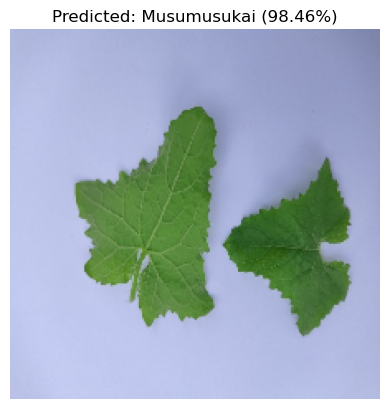

✅ Predicted Leaf: Musumusukai
✅ Confidence: 98.46%
🌿 Medicinal Use: Digestive health: Improves appetite and relieves indigestion.Antimicrobial: Effective against intestinal infections.Anti-inflammatory: Treats throat irritation and cough.Respiratory health: Relieves chest congestion and improves breathing.


In [9]:
from tensorflow.keras.preprocessing import image

def predict_leaf(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    
    predicted_label = class_labels[class_index]
    confidence = prediction[0][class_index] * 100
    
    # ✅ Show Image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f}%)")
    plt.show()
    
    # ✅ Print medicinal use
    print(f"✅ Predicted Leaf: {predicted_label}")
    print(f"✅ Confidence: {confidence:.2f}%")
    print(f"🌿 Medicinal Use: {medicinal_uses.get(predicted_label, 'No information available')}")
    
# ✅ Test Prediction
test_image = r"D:\test_image\IMG_20250119_094605.jpg"
predict_leaf(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


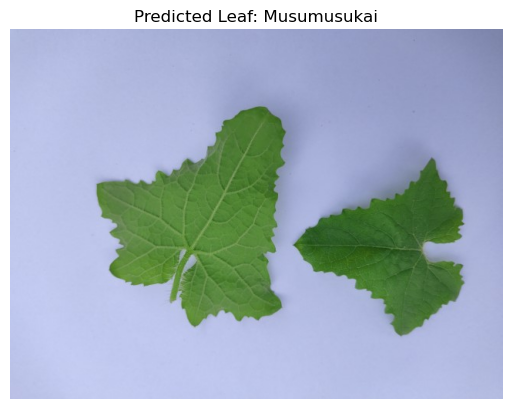

✅ Predicted Leaf: Musumusukai
✅ Confidence: 98.46%
🌿 Medicinal Use: Digestive health: Improves appetite and relieves indigestion.Antimicrobial: Effective against intestinal infections.Anti-inflammatory: Treats throat irritation and cough.Respiratory health: Relieves chest congestion and improves breathing.


In [10]:
# ✅ Function to predict leaf type and display medicinal uses
def predict_leaf(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Predict class
    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    
    # ✅ Get class labels from model
    class_labels = list(medicinal_uses.keys())
    predicted_label = class_labels[class_index]
    
    # ✅ Display the image with prediction
    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predicted Leaf: {predicted_label}")
    plt.show()
    
    # ✅ Print predicted class and confidence
    confidence = prediction[0][class_index] * 100
    print(f"✅ Predicted Leaf: {predicted_label}")
    print(f"✅ Confidence: {confidence:.2f}%")
    
    # ✅ Display medicinal uses
    if predicted_label in medicinal_uses:
        print(f"🌿 Medicinal Use: {medicinal_uses[predicted_label]}")
    else:
        print("❌ Medicinal use not found for this leaf.")

# ✅ Test with a sample image
test_image = r"D:\test_image\IMG_20250119_094605.jpg"
predict_leaf(test_image)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 428ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 467ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 444ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 402ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 400ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 415ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 401ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 398ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 395ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 413ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

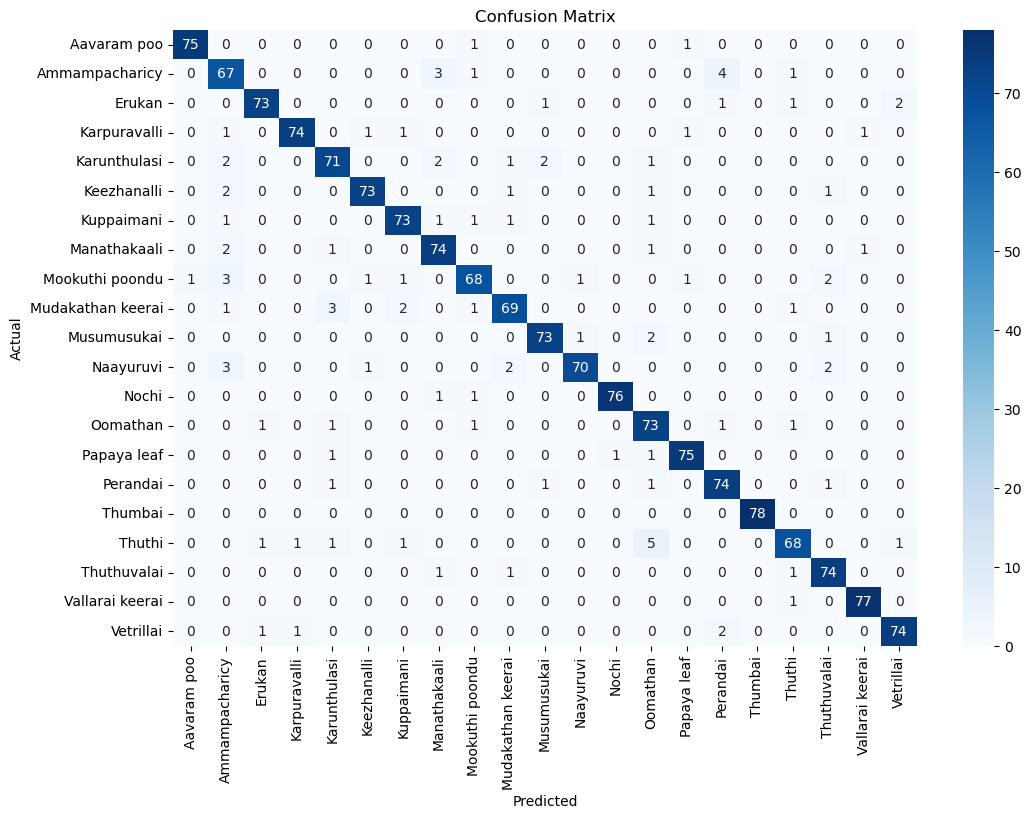

Classification Report:
                   precision    recall  f1-score   support

      Aavaram poo       0.99      0.97      0.98        77
   Ammampacharicy       0.82      0.88      0.85        76
           Erukan       0.96      0.94      0.95        78
     Karpuravalli       0.97      0.94      0.95        79
     Karunthulasi       0.90      0.90      0.90        79
      Keezhanalli       0.96      0.94      0.95        78
       Kuppaimani       0.94      0.94      0.94        78
     Manathakaali       0.90      0.94      0.92        79
  Mookuthi poondu       0.92      0.87      0.89        78
Mudakathan keerai       0.92      0.90      0.91        77
      Musumusukai       0.95      0.95      0.95        77
        Naayuruvi       0.97      0.90      0.93        78
            Nochi       0.99      0.97      0.98        78
         Oomathan       0.85      0.94      0.89        78
      Papaya leaf       0.96      0.96      0.96        78
         Perandai       0.90    

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels and predictions
true_labels = []
predicted_labels = []

for images, labels in val_generator:
    preds = model.predict(images)
    true_labels.extend(np.argmax(labels, axis=1))  # True class index
    predicted_labels.extend(np.argmax(preds, axis=1))  # Predicted class index
    
    if len(true_labels) >= val_generator.samples:  # Stop after all validation samples
        break

# Get class names
class_labels = list(train_generator.class_indices.keys())

# Compute Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))


In [12]:
model.save('medicinal_leaf_model.h5')
print("✅ Model Saved Successfully!")


✅ Model Saved Successfully!
